Loaded RAW: (200000, 24)
Data Overview: {'shape': (200000, 24), 'dtypes': {dtype('O'): 20, dtype('int64'): 2, dtype('float64'): 2}, 'duplicates': np.int64(0), 'missing_total': np.int64(0), 'memory_usage_mb': np.float64(249.58870124816895)}


INFO:eda_utils_prod:No missing values found.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:root:Dropping irrelevant columns: ['Customer_ID', 'Customer_Name', 'Merchant_ID', 'Customer_Contact', 'Customer_Email', 'Transaction_ID', 'Transaction_Description', 'Transaction_Currency']


Applying Advanced Feature Engineering...
✅ Saved Frequency Maps to ../model/freq_maps.pkl
✅ Saved Unique Values for ['Gender', 'Account_Type', 'Transaction_Type', 'Merchant_Category', 'Transaction_Device', 'Device_Type'] to ../model/unique_values.pkl
Saved CLEAN CSV: (200000, 19)


INFO:root:One-hot encoding columns: ['Gender', 'Account_Type', 'Transaction_Type', 'Merchant_Category', 'Transaction_Device', 'Device_Type']


Saved FEATURES CSV: (200000, 53)


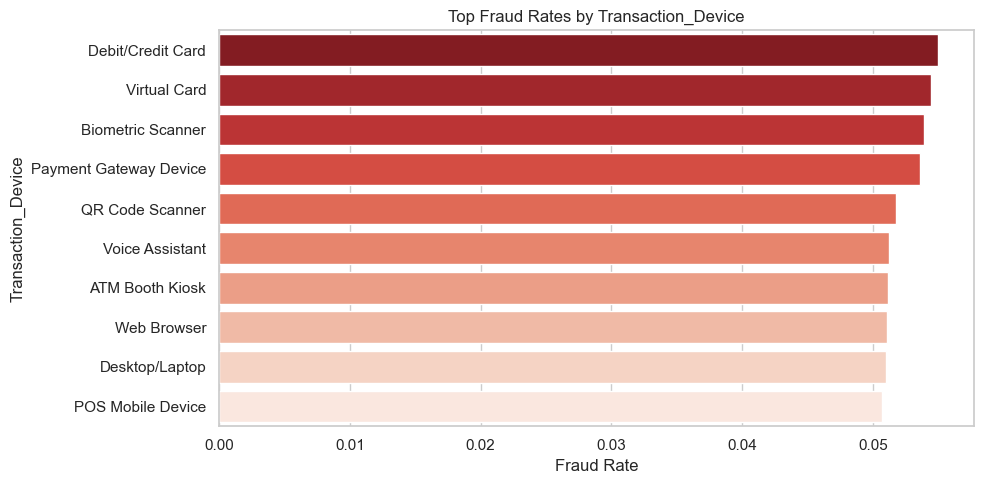

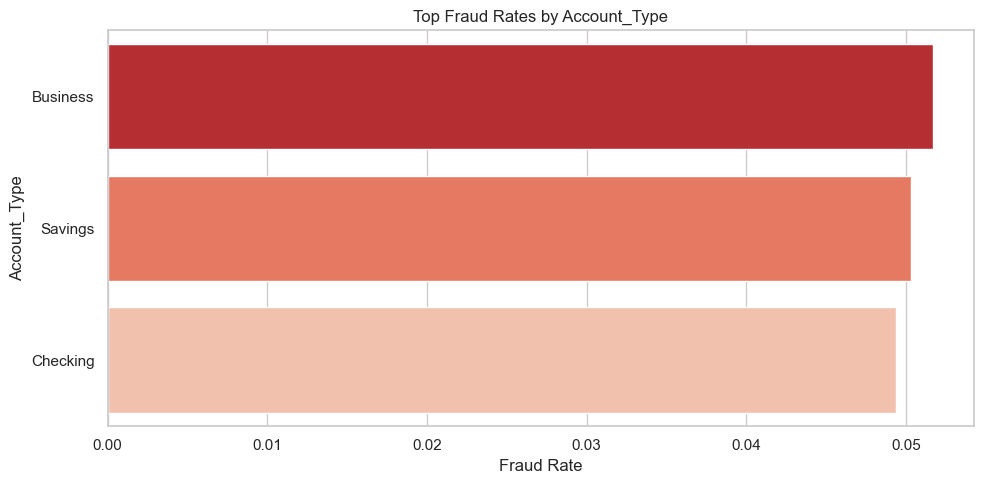

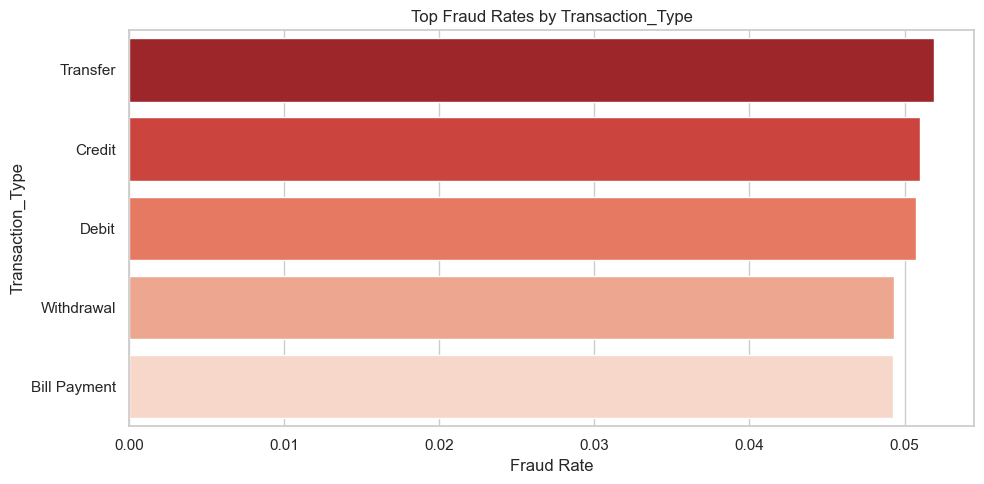

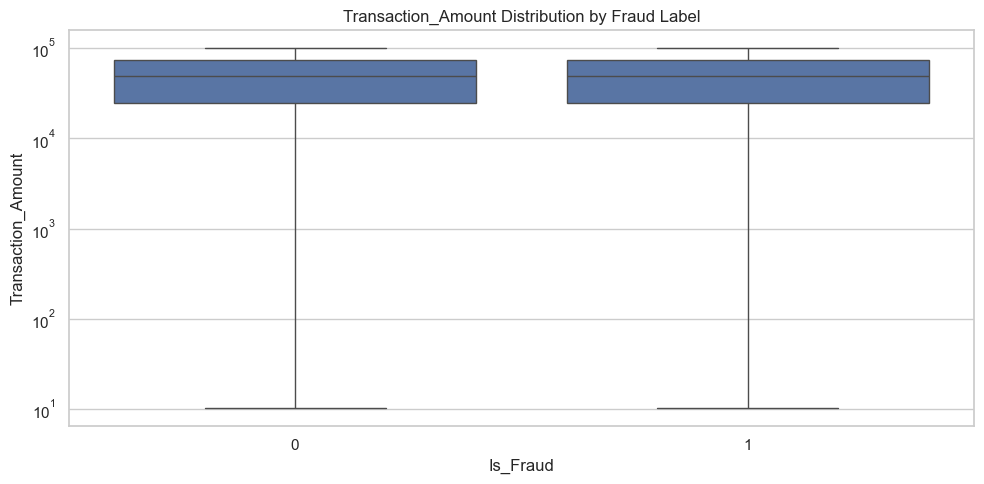

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # <--- NEW: Needed to save metadata
import os      # <--- NEW: Needed for directory creation
from typing import Optional, List, Tuple, Dict, Any

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Display Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.options.display.max_columns = 120
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src/")

import pandas as pd
from eda_utils_prod import (
    overview,
    eda_descriptive,
    numeric_eda,
    categorical_summary,
    missing_heatmap,
    class_imbalance,
    fraud_rate_by_feature,
    fraud_by_time,
    amount_outlier_analysis,
    feature_cardinality
)
# Ensure your preprocessing.py has been updated to return (df, freq_maps)
from preprocessing import (
    clean_missing,
    drop_irrelevant_columns,
    feature_engineering_advanced,
    encode_categorical
)

# =====================================================
# 1. Load RAW CSV
# =====================================================
df_raw = pd.read_csv("../data/raw/Bank_Transaction_Fraud_Detection.csv")
print("Loaded RAW:", df_raw.shape)

overview_stats = overview(df_raw)
print("Data Overview:", overview_stats)

# =====================================================
# 2. EDA (RAW DATA)
# =====================================================
eda_descriptive(df_raw)
numeric_eda(df_raw)
categorical_summary(df_raw)
missing_heatmap(df_raw)

# ---- Fraud-specific EDA ----
class_imbalance(df_raw)

fraud_rate_by_feature(df_raw, feature="Transaction_Device")
fraud_rate_by_feature(df_raw, feature="Account_Type")
fraud_rate_by_feature(df_raw, feature="Transaction_Type")

fraud_by_time(df_raw)
amount_outlier_analysis(df_raw)
feature_cardinality(df_raw)

# =====================================================
# 3. CLEANING & FEATURE ENGINEERING
# =====================================================
df_clean = clean_missing(df_raw)

df_clean = drop_irrelevant_columns(df_clean, [
    "Customer_ID",
    "Customer_Name",
    "Merchant_ID",
    "Customer_Contact",
    "Customer_Email",
    "Transaction_ID",
    "Transaction_Description",
    "Transaction_Currency"
])

# --- CRITICAL UPDATE START ---
# We now capture the 'freq_maps' returned by the updated function
print("Applying Advanced Feature Engineering...")
df_clean, freq_maps = feature_engineering_advanced(df_clean)

# Ensure the model directory exists
os.makedirs("../model", exist_ok=True)

# 1. SAVE FREQUENCY MAPS (e.g., {'City': {'New York': 0.05...}})
# The dashboard needs this to encode new inputs like "New York"
joblib.dump(freq_maps, "../model/freq_maps.pkl")
print("✅ Saved Frequency Maps to ../model/freq_maps.pkl")

# 2. SAVE UNIQUE VALUES FOR ONE-HOT COLUMNS
# We identify which text columns remain (e.g., Transaction_Type, Device)
# These will become One-Hot encoded later, but the dashboard needs the raw lists.
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
unique_values = {col: sorted(df_clean[col].dropna().unique().tolist()) for col in cat_cols}

joblib.dump(unique_values, "../model/unique_values.pkl")
print(f"✅ Saved Unique Values for {list(unique_values.keys())} to ../model/unique_values.pkl")
# --- CRITICAL UPDATE END ---

# =====================================================
# 4. SAVE CLEAN DATA (for Streamlit & rules)
# =====================================================
# This CSV contains the processed data BEFORE One-Hot Encoding
# (Useful for debugging or rule-based logic)
df_clean.to_csv(
    "../data/processed/bank_transactions_clean.csv",
    index=False
)
print("Saved CLEAN CSV:", df_clean.shape)

# =====================================================
# 5. ENCODE FOR ML ONLY
# =====================================================
# This transforms remaining text columns (Transaction_Type, etc.) into 0s and 1s
df_features = encode_categorical(
    df_clean.copy(),
    drop_first=False, # Often False is better for Random Forest interpretability
    max_cardinality=50
)

df_features.to_csv(
    "../data/processed/bank_transactions_features.csv",
    index=False
)
print("Saved FEATURES CSV:", df_features.shape)